In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, Math, display

import numpy as np

In [2]:
def bungee_jumper_velocity(m, cd, t, g=9.8):
    return np.sqrt(g * m / cd) * np.tanh(np.sqrt(g*cd/m) * t)

def bungee_jumper_acceleration(m, cd, v, g=9.8):
    return g - (cd * v ** 2 /m)

data = dict(
    m=68.1,
    cd=0.25,
    v0=0,
    dt=1,
    t0=0,
    t_final=20,
)

acceleration = lambda  y,t: bungee_jumper_acceleration(m=data['m'], cd=data['cd'], v=y, g=9.8)

# Solve Analytically

$$ \frac{dv}{dt} = g - \frac{C_d v^2}{m} $$
$$ v(t) = \sqrt{\frac{m g}{C_d}} \tanh{(\sqrt{\frac{g C_d}{m}} t)}  $$


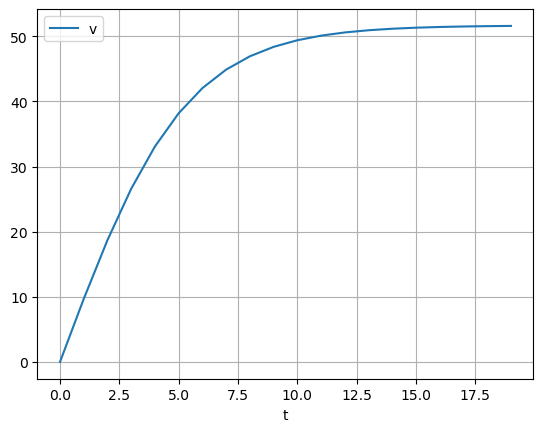

In [3]:
analytical_df = pd.DataFrame(
    data=dict(
        t=np.arange(data['t0'], data['t_final'], data['dt'])
    )
)
analytical_df['v'] = bungee_jumper_velocity(
    m=data['m'], cd=data['cd'], t=analytical_df['t'], g=9.8)

analytical_df.plot(x='t', y='v', linestyle='-')
df_all = analytical_df.copy()
df_all.rename(columns={'v': 'analytical'}, inplace=True)
plt.grid()

In [4]:
def align_solver_data(solver_df, df, solver_name):
    """
    Aligns time points between solver result and the collection dataframe,
    then adds the solver's velocity data to the collection dataframe.

    Parameters:
    -----------
    solver_df : pd.DataFrame
        Result dataframe from the solver with 't' and 'v' columns
    df : pd.DataFrame
        Collection dataframe for velocity values from all solvers
    solver_name : str
        Name of the solver to use as column name

    Returns:
    --------
    pd.DataFrame
        Updated df_all dataframe with new solver data
    """
    # Make sure we're not modifying the original dataframe
    df = df.copy()

    # Extract solver data with renamed column
    solver_data = solver_df[['t', 'v']].copy()
    solver_data = solver_data.rename(columns={'v': solver_name})

    # Merge with existing collection dataframe
    df = pd.merge(
        df,
        solver_data,
        on='t',
        how='outer'
    )

    return df


def calculate_error(df, reference_col='analytical'):
    """
    Calculates error for all solver columns in df compared to the reference column.

    Parameters:
    -----------
    df : pd.DataFrame
        Collection dataframe with velocity values from all solvers
    reference_col : str
        Name of the column to use as reference (typically the analytical solution)

    Returns:
    --------
    pd.DataFrame
        Error dataframe with columns for each solver's error
    """
    # Create a new dataframe with only the time column
    df_err = pd.DataFrame({'t': df['t']})

    # Get all solver columns (excluding time and reference)
    solver_cols = [col for col in df.columns if col != 't' and col != reference_col]

    # Calculate errors for each solver
    for solver in solver_cols:
        df_err[solver] = (df[solver] - df[reference_col]).abs()

    return df_err

# Euler Method

In [5]:
from ODE.RungeKutta.RKEulerMethod import RKEulerMethod

solver_euler = RKEulerMethod(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Euler Method Butcher tableau}'))
display(Math(solver_euler.butcher_tableau))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
df_euler =solver_euler.run()
clear_output()

In [7]:
df_all = align_solver_data(
    solver_name='euler',
    solver_df=df_euler,
    df=df_all
)
df_euler

,v,t,dy_dt
0,0.000000,0,9.800000
1,9.800000,1,9.447430
2,19.247430,2,8.440002
3,27.687432,3,6.985779
4,34.673211,4,5.386522
5,40.059732,5,3.908729
6,43.968461,6,2.702990
7,46.671451,7,1.803582
8,48.475033,8,1.173609
9,49.648642,9,0.750853


# HeunMethod

In [8]:
from ODE.RungeKutta.RKHeunMethod import RKHeunMethod
solver_heun = RKHeunMethod(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Heun Method Butcher tableau}'))
display(Math(solver_heun.butcher_tableau))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
df_heun = solver_heun.run()
clear_output()

In [10]:
df_all = align_solver_data(
    solver_name='heun',
    solver_df=df_heun,
    df=df_all
)
df_heun

,v,t,dy_dt
0,0.000000,0,9.800000
1,9.623715,1,9.460000
2,18.585235,2,8.531972
3,26.401472,3,7.241124
4,32.844530,4,5.839783
5,37.917586,5,4.521941
6,41.772548,6,3.394179
7,44.625083,7,2.489435
8,46.695318,8,1.795401
9,48.177031,9,1.279345


# RungeKutta4

In [11]:
from ODE.RungeKutta.RungeKutta4 import RungeKutta4

solver_rk4 = RungeKutta4(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta 4 Butcher tableau}'))
display(Math(solver_rk4.butcher_tableau))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
df_rk4 = solver_rk4.run()
clear_output()

In [13]:
df_all = align_solver_data(
    solver_name='rk4',
    solver_df=df_rk4,
    df=df_all
)
df_rk4

,v,t,dy_dt
0,0.000000,0,9.800000
1,9.684036,1,9.455725
2,18.710698,2,8.514794
3,26.589751,3,7.204498
4,33.082409,4,5.782211
5,38.183598,5,4.447624
6,42.043512,6,3.310804
7,44.881855,7,2.405063
8,46.925413,8,1.716320
9,48.374495,9,1.209355


# RK Cash Karp

In [24]:
from ODE.RungeKutta.RKCashKarp import RKCashKarp

solver_cash_karp = RKCashKarp(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta cash-karp Butcher tableau}'))
display(Math(solver_cash_karp.butcher_tableau))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
df_cash_karp = solver_cash_karp.run()
clear_output()
df_all = align_solver_data(
    solver_name='cash_karp',
    solver_df=df_cash_karp,
    df=df_all
)

# Runge Kutta bogacki-shampine

In [25]:
from ODE.RungeKutta.RKBogackiShampine import RKBogackiShampine

solver_bogacki_shampine = RKBogackiShampine(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta bogacki-shampine Butcher tableau}'))
display(Math(solver_bogacki_shampine.butcher_tableau))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [26]:
df_bogacki_shampine = solver_bogacki_shampine.run()
clear_output()
df_all = align_solver_data(
    solver_name='bogacki_shampine',
    solver_df=df_bogacki_shampine,
    df=df_all
)

# RKButcher5thOrder

In [28]:
from ODE.RungeKutta.RKButcher5thOrder import RKButcher5thOrder

solver_butcher5 = RKButcher5thOrder(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta 5 Butcher tableau}'))
display(Math(solver_butcher5.butcher_tableau))
df_butcher5 = solver_butcher5.run()
clear_output()
df_all = align_solver_data(
    solver_name='butcher5',
    solver_df=df_butcher5,
    df=df_all
)

# RKButcher6thOrder

In [29]:
from ODE.RungeKutta.RKButcher6thOrder import RKButcher6thOrder

solver_butcher6 = RKButcher6thOrder(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta 6 Butcher tableau}'))
display(Math(solver_butcher6.butcher_tableau))
df_butcher6 = solver_butcher6.run()
clear_output()
df_all = align_solver_data(
    solver_name='butcher6',
    solver_df=df_butcher6,
    df=df_all
)

#RKDormandPrince54

In [30]:
from ODE.RungeKutta.RKDormandPrince54 import RKDormandPrince54

solver_dormand_prince54 = RKDormandPrince54(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta dormand prince54'))
display(Math(solver_dormand_prince54.butcher_tableau))
df_dormand_prince54 = solver_dormand_prince54.run()
clear_output()
df_all = align_solver_data(
    solver_name='dormand_prince54',
    solver_df=df_dormand_prince54,
    df=df_all
)

# RKFehlberg45

In [31]:
from ODE.RungeKutta.RKFehlberg45 import RKFehlberg45

solver_fehlberg45 = RKFehlberg45(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta fehlberg45'))
display(Math(solver_fehlberg45.butcher_tableau))
df_fehlberg45 = solver_fehlberg45.run()
clear_output()
df_all = align_solver_data(
    solver_name='fehlberg45',
    solver_df=df_fehlberg45,
    df=df_all
)

# RKMidpointMethod

In [32]:
from ODE.RungeKutta.RKMidpointMethod import RKMidpointMethod

solver_midpoint = RKMidpointMethod(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta midpoint Butcher tableau}'))
display(Math(solver_midpoint.butcher_tableau))
df_midpoint = solver_midpoint.run()
clear_output()
df_all = align_solver_data(
    solver_name='midpoint',
    solver_df=df_midpoint,
    df=df_all
)

In [33]:
from ODE.RungeKutta.RKRalstonMethod import RKRalstonMethod

solver_ralston = RKRalstonMethod(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta ralston Butcher tableau}'))
display(Math(solver_ralston.butcher_tableau))
df_ralston = solver_ralston.run()
clear_output()
df_all = align_solver_data(
    solver_name='ralston',
    solver_df=df_ralston,
    df=df_all
)

# Results

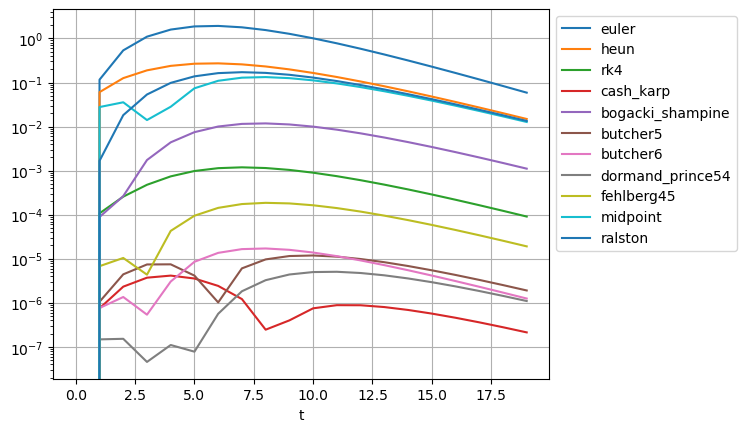

In [37]:
df_error = calculate_error(df_all)
df_error.plot(x='t', y=['euler', 'heun', 'rk4', 'cash_karp', 'bogacki_shampine', 'butcher5', 'butcher6', 'dormand_prince54', 'fehlberg45', 'midpoint', 'ralston'])
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot

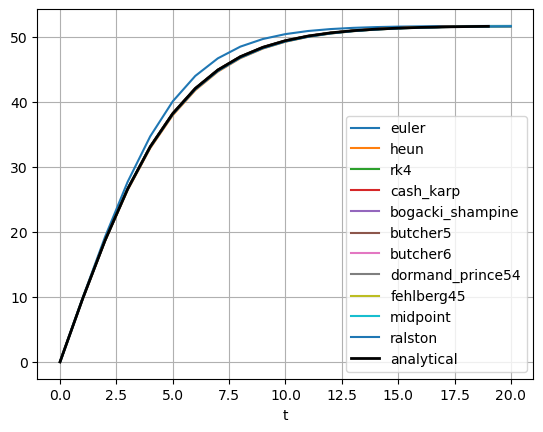

In [42]:
fig, ax = plt.subplots()
df_all.plot(x='t', y=['euler', 'heun', 'rk4', 'cash_karp', 'bogacki_shampine', 'butcher5', 'butcher6', 'dormand_prince54', 'fehlberg45', 'midpoint', 'ralston'],ax=ax)
df_all.plot(x='t', y='analytical', ax=ax, linewidth=2.0, color='k')
plt.grid()